In [1]:
from copy import deepcopy
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, make_scorer, mean_absolute_error as mae
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from tqdm import tqdm
from collections import Counter

In [ ]:
tqdm.

In [4]:
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'Ridge': Ridge(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet()
}


def set_params(func, parameters):
    for parameter, value in parameters.items():
        if hasattr(func, parameter):
            setattr(func, parameter, value)
    return func


gfoo = '../gold_split/'
g1 = pd.read_csv(gfoo + 'traincorr1.csv', index_col=[0, 1, 2])
g2 = pd.read_csv(gfoo + 'testcorr1.csv', index_col=[0,1, 2])
g = pd.concat([g1, g2])


wbs = ['Diener', 'WHO']
feats = ['clusters', 'words', 'Meta', 'AppCats', 'RuLIWC']
indeces = [[0, 1], [0, 1], [0, 1, 2], [0, 1, 2], [0, 1, 2]]

appdata1 = pd.read_csv('AppCatsBy3HoursNorm-1.csv', index_col=0)
data = {'clusters': {}}

whodata = pd.read_csv(gfoo + 'h-clustersVERYRARE_WHO.csv', index_col = [0,1])
dienerdata = pd.read_csv(gfoo + 'h-clustersRARE_Diener.csv', index_col = [0,1])
data['clusters']['WHO'] = g.join(whodata)[whodata.columns]
data['clusters']['Diener'] = g.join(dienerdata)[dienerdata.columns]

data['AppCats'] = g.join(appdata1, lsuffix = 'mail')[appdata1.columns]

wdf1 = pd.read_csv('RuLIWC-matrix-1year-traintest.csv', index_col = [0,1,2])
data['RuLIWC'] = g.join(wdf1, rsuffix = 'APP_')[wdf1.columns]

cols = g.dropna(axis=1).columns
cols = cols[2:]
cols = cols.drop(['MessNewest', 'MessOldest'])
data['Behavior'] = g[cols]

data['Words'] = pd.read_csv(gfoo+'words_selected.csv', index_col = [0,1,2])

rat = {'who': 25., 'diener': 30.}
metrs = ['MAE', 'Pearson', 'R-2']

wb = 'WHO'
fs = ['clusters', 'Words', "RuLIWC", "AppCats", "Behavior"]


prepared_data_frames = [data[x][wb] if x == 'clusters' else data[x] for x in fs]

traindata = pd.concat(prepared_data_frames, axis=1)


def get_features_index(prepared_data_frames, fs):
    prepared_columns_index = {}
    current_col_index = 0
    for i, feature_name in zip(prepared_data_frames, fs):
        prepared_columns_index[feature_name] = (current_col_index, current_col_index + i.shape[1])
        current_col_index += i.shape[1]
    return prepared_columns_index

prepared_columns_index = get_features_index(prepared_data_frames, fs)

mapping = {
    "clusters":
        ("RandomForestRegressor",
         {"max_depth": 3,
          "max_features": "auto",
          "min_samples_leaf": 1,
          "min_samples_split": 2,
          "n_estimators": 20,
          "random_state": 42}),

    "Words":
        ("AdaBoostRegressor",
         {"loss": "square",
          "n_estimators": 100,
          "random_state": 42}),

    "RuLIWC":
        ("Lasso",
         {"alpha": 0.0001,
          "max_iter": 500,
          "normalize": False,
          "selection": "cyclic",
          "random_state": 42}),

    "AppCats":
        ("Ridge",
         {"alpha": 1,
          "normalize": False}),

    "Behavior":
        ("DecisionTreeRegressor",
         {"criterion": "mae",
          "max_depth": 2,
          "max_features": "auto",
          "max_leaf_nodes": 3,
          "min_samples_leaf": 2,
          "min_samples_split": 2,
          "splitter": "best",
          "random_state": 42})
}


In [5]:
diener_mapping = {
    "clusters": 
        ("RandomForestRegressor", 
         {"max_depth": 3, 
          "max_features": "auto", 
          "min_samples_leaf": 1, 
          "min_samples_split": 2, 
          "n_estimators": 20, 
          "random_state": 42}),
    
    "Words": 
        ("ElasticNet",
         {"alpha": 0.01, 
          "l1_ratio": 0.75, 
          "max_iter": 500, 
          "normalize": True, 
          "selection": "random", 
          "random_state": 42}),
    
    "RuLIWC": 
        ("RandomForestRegressor",
         {"max_depth": 3, 
          "max_features": "auto", 
          "min_samples_leaf": 1, 
          "min_samples_split": 2, 
          "n_estimators": 10, 
          "random_state": 42}),
    
    "AppCats": 
        ("Lasso", 
        {"alpha": 0.01, 
         "max_iter": 500, 
         "normalize": False, 
         "selection": "random", 
         "random_state": 42}),
    
    "Behavior": 
        ("DecisionTreeRegressor",
         {"criterion": "mae", 
          "max_depth": 2, 
          "max_features": "auto", 
          "max_leaf_nodes": 3, 
          "min_samples_leaf": 2, 
          "min_samples_split": 2, 
          "splitter": "best", 
          "random_state": 42})
}

In [6]:
def eval_pars_nested_CV(
        X, y, wb, mapping_models, mapping_features,
        step=1, bestfs=False
):
    wb = wb.lower()
    sortedarg = np.asarray(y.argsort())
    cv = []
    X = np.asarray(X)
    y = np.asarray(y)
    for i in range(5):
        for j in range(2):
            if j:
                di = i * 2
                ti = i * 2 + 1
            else:
                di = i * 2 + 1
                ti = i * 2
            dev = sortedarg[di::10]
            test = sortedarg[ti::10]
            train = np.setdiff1d(sortedarg, np.concatenate((dev, test)))
            cv.append([train, dev, test])

    maes, prs, r2s = [], [], []
    devmaes = []
    trues = []
    preds_mean, preds_mean_round, preds_vote = [], [], []
    bestfeats, ests = [], []

    for i, [train, dev, test] in enumerate(cv):
        print(f"Cross-validation #{i}")
        estimator_predictions = []
        for feature_name, (model_name, model_params) in tqdm(
                mapping_models.items(), desc=f"Model predicting in CV #{i}"):

            feature_loc = mapping_features[feature_name]

            X_features = X[:, feature_loc[0]: feature_loc[1]]

            est = set_params(deepcopy(models[model_name]), model_params)

            fs = RFECV(
                est,
                cv=[[train, dev]],
                scoring=make_scorer(mae, greater_is_better=False),
                step=step,
                verbose=False
            )

            fs.fit(X_features, y)

            if bestfs:
                bestfeats.append(fs.support_)
                ests.append(fs.estimator_)
            resmae = fs.grid_scores_.max() / - rat[wb]

            devmaes.append(resmae)
            est = set_params(deepcopy(models[model_name]), model_params)

            est.fit(
                fs.transform(np.concatenate((X_features[train], X_features[dev]))),
                np.concatenate((y[train], y[dev]))
            )
            test_predictions = est.predict(fs.transform(X_features[test]))
            estimator_predictions.append(test_predictions)

        # create mean predictions
        test_predictions = np.zeros(estimator_predictions[0].shape)
        for pred in estimator_predictions:
            test_predictions += pred
        test_predictions = test_predictions / len(estimator_predictions)

        preds_mean += list(test_predictions)

        # create mean round predictions
        round_test_preds = np.round(test_predictions)
        preds_mean_round += list(round_test_preds)

        vote_preds = []
        for index, _ in enumerate(estimator_predictions[0]):
            sample_preds = []
            for est_index, _ in enumerate(estimator_predictions):
                sample_preds.append(round(estimator_predictions[est_index][index]))
            count = Counter(sample_preds)
            if len(count) == len(sample_preds):
                v = sum(sample_preds) / len(sample_preds)
            else:
                v = count.most_common(1)[0][0]
            vote_preds.append(v)

        preds_vote += list(vote_preds)

        # true
        trues += list(y[test])

        mae_score, pearson_score, r_score = [], [], []
        for preds, name in zip(
                [test_predictions, round_test_preds, vote_preds],
                ["MEAN", "MEAN and ROUND", "ROUND and VOTE"]
        ):
            print(name)
            mae_sc = mae(y[test], preds) / rat[wb]
            mae_score.append(mae_sc)

            pearson_sc = pearsonr(y[test], preds)[0]
            if np.isnan(pearson_sc):
                pearson_sc = 0.0
            pearson_score.append(pearson_sc)

            r_sc = r2_score(y[test], preds)
            r_score.append(r_sc)
            print(f"CV: pr {pearson_sc}, r2 {r_sc} mae {mae_sc}")

        maes.append(mae_score)
        prs.append(pearson_score)
        r2s.append(r_score)

    print('Dev final: ', round(np.mean(devmaes), 4), flush=True)
    print('Test mean: ', [round(np.mean([v[0] for v in x]), 4) for x in [maes, prs, r2s]], flush=True)
    print('Test mean round: ', [round(np.mean([v[1] for v in x]), 4) for x in [maes, prs, r2s]], flush=True)
    print('Test round vote: ', [round(np.mean([v[2] for v in x]), 4) for x in [maes, prs, r2s]], flush=True)

    return (trues, preds_mean, preds_mean_round, preds_vote, bestfeats, ests)

In [7]:
import warnings
warnings.filterwarnings("ignore")

## Diener

In [35]:
d_trues, d_preds_mean, d_preds_mean_round, d_preds_vote, d_bestfeats, d_ests = eval_pars_nested_CV(
    X=traindata, 
    y=g['DF_' + "diener" + '_score'], 
    wb=wb, 
    mapping_models=diener_mapping,
    mapping_features=prepared_columns_index,
    step=1, 
    bestfs=True
)

Model predicting in CV #0:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation #0


Model predicting in CV #1:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.5181782339002492, r2 0.1399739806851733 mae 0.20845598656688188
MEAN and ROUND
CV: pr 0.48757481138332426, r2 0.13140692424911338 mae 0.2094736842105263
ROUND and VOTE
CV: pr 0.27137657872292387, r2 0.06834869048805836 mae 0.2109473684210526
Cross-validation #1


Model predicting in CV #2:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.5018412735696283, r2 0.15024738881628052 mae 0.20880953661522864
MEAN and ROUND
CV: pr 0.5013145477858039, r2 0.15452375539895435 mae 0.20842105263157895
ROUND and VOTE
CV: pr 0.2525478044845804, r2 0.06321664014548778 mae 0.21768421052631579
Cross-validation #2


Model predicting in CV #3:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.1613997249426144, r2 0.019712618455346664 mae 0.2143868761610869
MEAN and ROUND
CV: pr 0.2385986885047527, r2 0.040362185389809624 mae 0.2108108108108108
ROUND and VOTE
CV: pr 0.09496656931259104, r2 0.004424664074755946 mae 0.21513513513513513
Cross-validation #3


Model predicting in CV #4:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.35912987767050236, r2 0.08693937722945688 mae 0.20823721247322605
MEAN and ROUND
CV: pr 0.3295915823051956, r2 0.07825616030327653 mae 0.20972972972972972
ROUND and VOTE
CV: pr 0.3253170935398103, r2 0.0934849715678312 mae 0.20886486486486486
Cross-validation #4


Model predicting in CV #5:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.4576038812145385, r2 0.11768696833525605 mae 0.20361079230236126
MEAN and ROUND
CV: pr 0.4633905661919852, r2 0.1285329744279945 mae 0.20216216216216218
ROUND and VOTE
CV: pr 0.3016189686583689, r2 0.0782751837664355 mae 0.19697297297297298
Cross-validation #5


Model predicting in CV #6:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.2825380967319509, r2 0.06931681520406696 mae 0.2060452474593313
MEAN and ROUND
CV: pr 0.2929000748900722, r2 0.07380787151779511 mae 0.20432432432432432
ROUND and VOTE
CV: pr 0.033048456652339464, r2 -0.0378731700869106 mae 0.21794594594594593
Cross-validation #6


Model predicting in CV #7:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.530336329138926, r2 0.14758124504590409 mae 0.20184506169577218
MEAN and ROUND
CV: pr 0.5670570317550633, r2 0.15816820499580486 mae 0.20108108108108108
ROUND and VOTE
CV: pr 0.3518081729415592, r2 0.09153811398696221 mae 0.2067027027027027
Cross-validation #7


Model predicting in CV #8:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.28333662773843565, r2 0.06825649630035302 mae 0.2173555945862364
MEAN and ROUND
CV: pr 0.31888765148910403, r2 0.08142238359131149 mae 0.21513513513513513
ROUND and VOTE
CV: pr 0.17767353702542013, r2 0.025989553474743632 mae 0.2250810810810811
Cross-validation #8


Model predicting in CV #9:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.33677422737507123, r2 0.06587630777703202 mae 0.21171034844652517
MEAN and ROUND
CV: pr 0.38351242434953214, r2 0.0737630059688833 mae 0.20864864864864863
ROUND and VOTE
CV: pr 0.14065209987289076, r2 0.014990704197788363 mae 0.21664864864864863
Cross-validation #9


Model predicting in CV #9: 100%|██████████| 5/5 [00:23<00:00,  4.70s/it]

MEAN
CV: pr 0.5320323381886172, r2 0.16521025494508956 mae 0.20440231679863605
MEAN and ROUND
CV: pr 0.5311687021423941, r2 0.18082067263991686 mae 0.20108108108108108
ROUND and VOTE
CV: pr 0.46407115088658024, r2 0.11622321776392674 mae 0.20691891891891892
Dev final:  0.2139
Test mean:  [0.2085, 0.3963, 0.1031]
Test mean round:  [0.2071, 0.4114, 0.1101]
Test round vote:  [0.2123, 0.2413, 0.0519]


Mean predictions


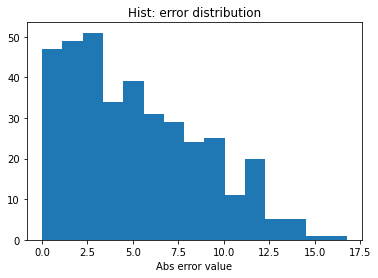

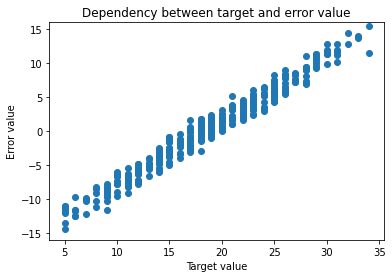

Mean and Round predictions


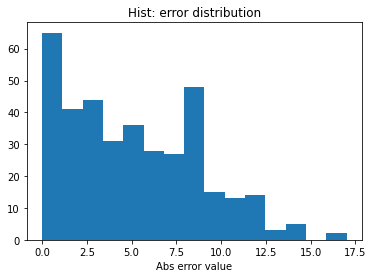

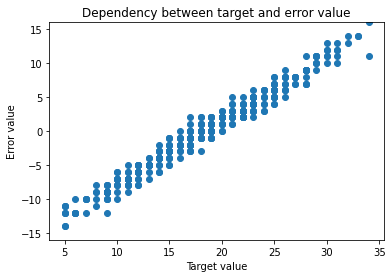

Round and vote predictions


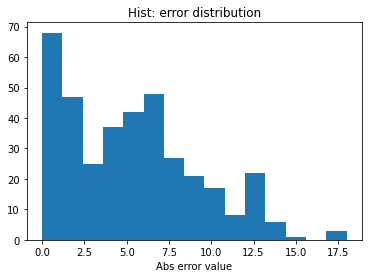

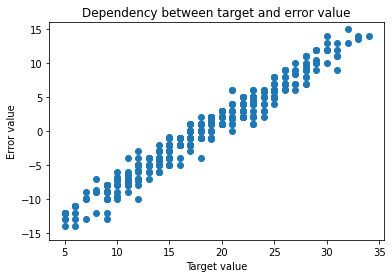

In [98]:
print("Mean predictions")
error_analysis(d_trues, d_preds_mean)
print("Mean and Round predictions")
error_analysis(d_trues, d_preds_mean_round)
print("Round and vote predictions")
error_analysis(d_trues, d_preds_vote)

## Who (rare clustering)

In [36]:
w_trues, w_preds_mean, w_preds_mean_round, w_preds_vote, w_bestfeats, w_ests = eval_pars_nested_CV(
    X=traindata, 
    y=g['DF_' + "who" + '_score'], 
    wb=wb, 
    mapping_models=mapping,
    mapping_features=prepared_columns_index,
    step=1, 
    bestfs=True
)

Model predicting in CV #0:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation #0


Model predicting in CV #1:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.3265743911232274, r2 0.08255657117098136 mae 0.15763660740132843
MEAN and ROUND
CV: pr 0.40565275328615413, r2 0.1100677853094788 mae 0.15473684210526314
ROUND and VOTE
CV: pr 0.4379824731601339, r2 0.1489587731970219 mae 0.14989473684210528
Cross-validation #1


Model predicting in CV #2:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.5015570514238414, r2 0.15924472405450707 mae 0.15090626419835756
MEAN and ROUND
CV: pr 0.43825102330330773, r2 0.1404112372334949 mae 0.15052631578947367
ROUND and VOTE
CV: pr 0.45271186101564437, r2 0.17331238317124043 mae 0.14989473684210528
Cross-validation #2


Model predicting in CV #3:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.4641410377960956, r2 0.14985799295135505 mae 0.14185383116216452
MEAN and ROUND
CV: pr 0.4718677980896647, r2 0.15620985010706645 mae 0.13945945945945945
ROUND and VOTE
CV: pr 0.1839987472927726, r2 0.01333333333333342 mae 0.15048648648648646
Cross-validation #3


Model predicting in CV #4:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.622833362878205, r2 0.20179096025269483 mae 0.13520442105765293
MEAN and ROUND
CV: pr 0.5806966655650938, r2 0.1833160621761658 mae 0.1372972972972973
ROUND and VOTE
CV: pr 0.3295630696309138, r2 0.0938003454231433 mae 0.144
Cross-validation #4


Model predicting in CV #5:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.5490302421638726, r2 0.2054994576610727 mae 0.13241235000212373
MEAN and ROUND
CV: pr 0.5057669342531051, r2 0.18735482989479446 mae 0.13297297297297297
ROUND and VOTE
CV: pr 0.3975288130665142, r2 0.14463724552534518 mae 0.13967567567567568
Cross-validation #5


Model predicting in CV #6:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.44120296744430243, r2 0.1437645257519038 mae 0.1389271864660787
MEAN and ROUND
CV: pr 0.3529793070961863, r2 0.10452335658423162 mae 0.1437837837837838
ROUND and VOTE
CV: pr 0.42053733008316063, r2 0.14612978228704288 mae 0.13772972972972974
Cross-validation #6


Model predicting in CV #7:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.42530897312216875, r2 0.13126237688982745 mae 0.13940363819374557
MEAN and ROUND
CV: pr 0.3937882815348539, r2 0.12426035502958588 mae 0.13837837837837838
ROUND and VOTE
CV: pr 0.30432379497950046, r2 0.09045894068408156 mae 0.14291891891891895
Cross-validation #7


Model predicting in CV #8:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.4267534302874433, r2 0.13035314912815432 mae 0.14133908995120545
MEAN and ROUND
CV: pr 0.444908101775715, r2 0.1448733763877803 mae 0.13945945945945945
ROUND and VOTE
CV: pr 0.17848963753595118, r2 -0.004350917930483922 mae 0.1517837837837838
Cross-validation #8


Model predicting in CV #9:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.6301849412526829, r2 0.19430447064652823 mae 0.13484630170555972
MEAN and ROUND
CV: pr 0.5958775387199973, r2 0.18858489892135144 mae 0.13405405405405404
ROUND and VOTE
CV: pr 0.49738150668262615, r2 0.15047217658404155 mae 0.1429189189189189
Cross-validation #9


Model predicting in CV #9: 100%|██████████| 5/5 [05:00<00:00, 60.08s/it]

MEAN
CV: pr 0.4456635008011987, r2 0.12990630103043643 mae 0.1440300132236284
MEAN and ROUND
CV: pr 0.45066883213922504, r2 0.13985799139755584 mae 0.14162162162162162
ROUND and VOTE
CV: pr 0.27715492613283316, r2 0.07498736942718653 mae 0.14854054054054056
Dev final:  0.1446
Test mean:  [0.1417, 0.4833, 0.1529]
Test mean round:  [0.1412, 0.464, 0.1479]
Test round vote:  [0.1458, 0.348, 0.1032]


Mean predictions


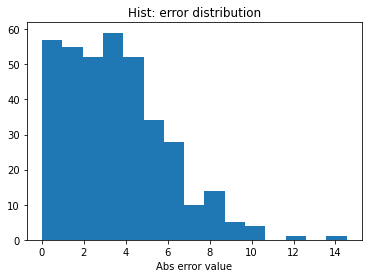

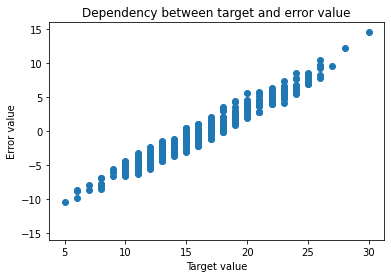

Mean and Round predictions


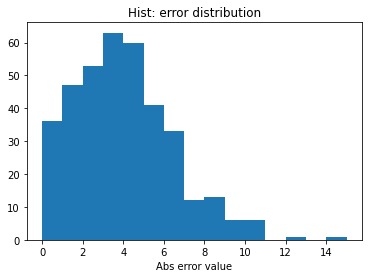

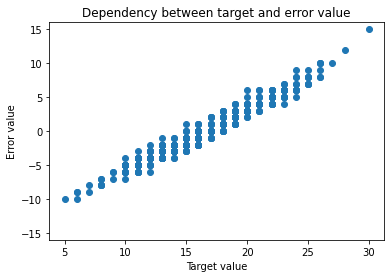

Round and vote predictions


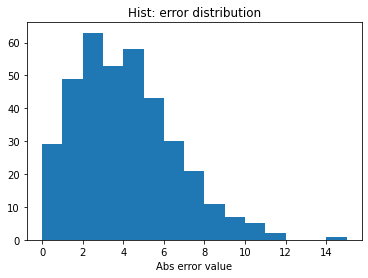

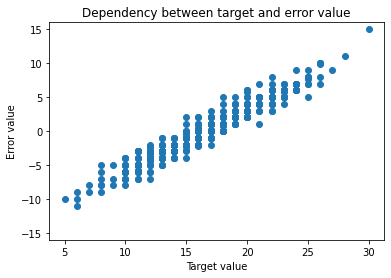

In [97]:
print("Mean predictions")
error_analysis(w_trues, w_preds_mean)
print("Mean and Round predictions")
error_analysis(w_trues, w_preds_mean_round)
print("Round and vote predictions")
error_analysis(w_trues, w_preds_vote)

## Who (simple clustering)

In [40]:
wbs = ['Diener', 'WHO']
feats = ['clusters', 'words', 'Meta', 'AppCats', 'RuLIWC']
indeces = [[0, 1], [0, 1], [0, 1, 2], [0, 1, 2], [0, 1, 2]]

appdata1 = pd.read_csv('AppCatsBy3HoursNorm-1.csv', index_col=0)
data = {'clusters': {}}

whodata = pd.read_csv(gfoo + 'h-clusters_WHO.csv', index_col = [0,1])
dienerdata = pd.read_csv(gfoo + 'h-clustersRARE_Diener.csv', index_col = [0,1])
data['clusters']['WHO'] = g.join(whodata)[whodata.columns]
data['clusters']['Diener'] = g.join(dienerdata)[dienerdata.columns]

data['AppCats'] = g.join(appdata1, lsuffix = 'mail')[appdata1.columns]

wdf1 = pd.read_csv('RuLIWC-matrix-1year-traintest.csv', index_col = [0,1,2])
data['RuLIWC'] = g.join(wdf1, rsuffix = 'APP_')[wdf1.columns]

cols = g.dropna(axis=1).columns
cols = cols[2:]
cols = cols.drop(['MessNewest', 'MessOldest'])
data['Behavior'] = g[cols]

data['Words'] = pd.read_csv(gfoo+'words_selected.csv', index_col = [0,1,2])

rat = {'who': 25., 'diener': 30.}
metrs = ['MAE', 'Pearson', 'R-2']

wb = 'WHO'
fs = ['clusters', 'Words', "RuLIWC", "AppCats", "Behavior"]


prepared_data_frames = [data[x][wb] if x == 'clusters' else data[x] for x in fs]

traindata = pd.concat(prepared_data_frames, axis=1)
prepared_columns_index = get_features_index(prepared_data_frames, fs)


In [41]:
ww_trues, ww_preds_mean, ww_preds_mean_round, ww_preds_vote, ww_bestfeats, ww_ests = eval_pars_nested_CV(
    X=traindata, 
    y=g['DF_' + "who" + '_score'], 
    wb=wb, 
    mapping_models=mapping,
    mapping_features=prepared_columns_index,
    step=1, 
    bestfs=True
)

Model predicting in CV #0:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation #0


Model predicting in CV #1:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.3749151234327785, r2 0.09936704109226746 mae 0.15637692535409384
MEAN and ROUND
CV: pr 0.38632434711585695, r2 0.09634403822646953 mae 0.15578947368421053
ROUND and VOTE
CV: pr 0.42485673558500126, r2 0.1456650738970996 mae 0.15157894736842104
Cross-validation #1


Model predicting in CV #2:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.4511256684007139, r2 0.1356920495373426 mae 0.1520008831246475
MEAN and ROUND
CV: pr 0.3873764786442655, r2 0.11364559911142413 mae 0.15473684210526314
ROUND and VOTE
CV: pr 0.38342102896115093, r2 0.11405737815945605 mae 0.15052631578947367
Cross-validation #2


Model predicting in CV #3:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.429103227195445, r2 0.13411513334833214 mae 0.1435209837517893
MEAN and ROUND
CV: pr 0.4010358213966413, r2 0.12847965738758038 mae 0.1427027027027027
ROUND and VOTE
CV: pr 0.3210365871862999, r2 0.09330192719486097 mae 0.15005405405405406
Cross-validation #3


Model predicting in CV #4:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.6267139105620991, r2 0.2091512448355085 mae 0.13483578546703442
MEAN and ROUND
CV: pr 0.5917481477782851, r2 0.19481865284974087 mae 0.1362162162162162
ROUND and VOTE
CV: pr 0.5667450059770306, r2 0.2307578583765112 mae 0.1308108108108108
Cross-validation #4


Model predicting in CV #5:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.5319112551145933, r2 0.19824291220985402 mae 0.13513225335400705
MEAN and ROUND
CV: pr 0.5703470358184854, r2 0.23158901489274497 mae 0.12972972972972974
ROUND and VOTE
CV: pr 0.26547542348369957, r2 0.06557179942615132 mae 0.14572972972972972
Cross-validation #5


Model predicting in CV #6:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.4966022199912616, r2 0.15697662326028305 mae 0.13833396616377786
MEAN and ROUND
CV: pr 0.44282726557012375, r2 0.14102022123582048 mae 0.13945945945945945
ROUND and VOTE
CV: pr 0.33887879466222826, r2 0.10499260198689497 mae 0.13924324324324325
Cross-validation #6


Model predicting in CV #7:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.3957775341445036, r2 0.11885970346278563 mae 0.14077780740974677
MEAN and ROUND
CV: pr 0.43201378400141976, r2 0.13360513782652628 mae 0.13945945945945945
ROUND and VOTE
CV: pr 0.38481946177735954, r2 0.13627507576850928 mae 0.13945945945945945
Cross-validation #7


Model predicting in CV #8:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.4963583477170241, r2 0.15947507939456218 mae 0.1385577540361582
MEAN and ROUND
CV: pr 0.5442941329128469, r2 0.1824613598432625 mae 0.13513513513513514
ROUND and VOTE
CV: pr 0.3133424794177851, r2 0.09488135839198897 mae 0.14832432432432432
Cross-validation #8


Model predicting in CV #9:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.6123711661838802, r2 0.18126673546220584 mae 0.13294128809159425
MEAN and ROUND
CV: pr 0.5897973489104765, r2 0.17536966926209008 mae 0.13405405405405404
ROUND and VOTE
CV: pr 0.408472848578329, r2 0.12087006214729612 mae 0.13816216216216215
Cross-validation #9


Model predicting in CV #9: 100%|██████████| 5/5 [05:01<00:00, 60.26s/it]

MEAN
CV: pr 0.379295693056404, r2 0.10139416884369223 mae 0.14670118357183634
MEAN and ROUND
CV: pr 0.3178408575984035, r2 0.08554652829931053 mae 0.14702702702702702
ROUND and VOTE
CV: pr 0.14470885494131863, r2 0.010167269748071472 mae 0.1561081081081081
Dev final:  0.1444
Test mean:  [0.1419, 0.4794, 0.1495]
Test mean round:  [0.1414, 0.4664, 0.1483]
Test round vote:  [0.145, 0.3552, 0.1117]


In [65]:
import matplotlib.pyplot as plt

In [95]:
def error_analysis(true, preds):
    errors = np.abs(np.array(true) - np.array(preds))
    plt.hist(errors, bins=15)
    plt.title("Hist: error distribution")
    plt.xlabel("Abs error value")

    plt.show()
    
    plt.scatter(true, np.array(true) - np.array(preds))
    plt.ylim((-16, 16))
    plt.title("Dependency between target and error value")
    plt.ylabel("Error value")
    plt.xlabel("Target value")
    plt.show()

Mean predictions


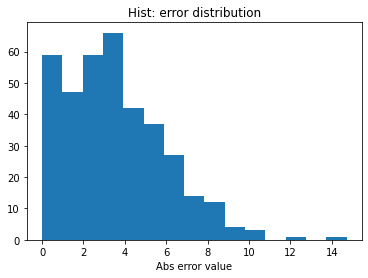

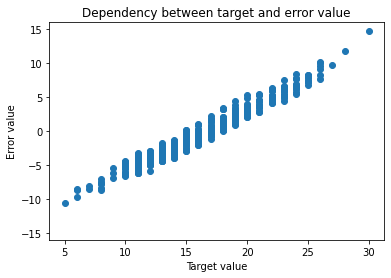

Mean and Round predictions


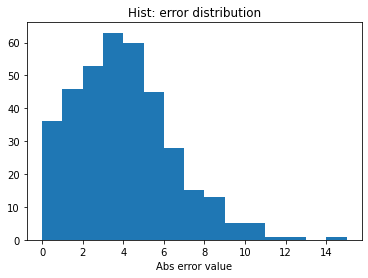

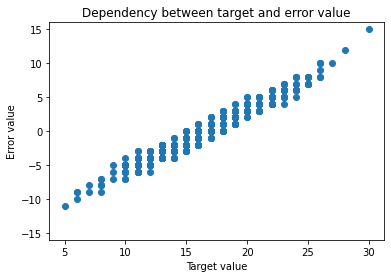

Round and vote predictions


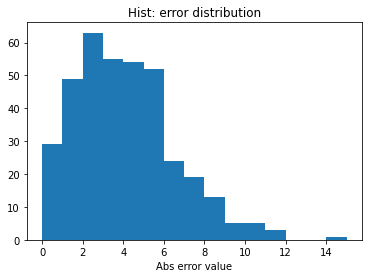

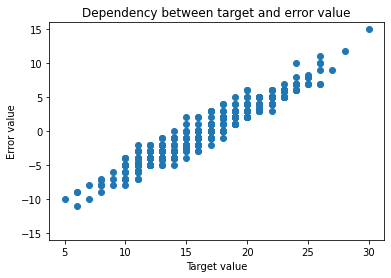

In [96]:
print("Mean predictions")
error_analysis(ww_trues, ww_preds_mean)
print("Mean and Round predictions")
error_analysis(ww_trues, ww_preds_mean_round)
print("Round and vote predictions")
error_analysis(ww_trues, ww_preds_vote)

In [114]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True)
lr.fit(np.expand_dims(ww_trues, 1), np.array(ww_trues) - np.array(ww_preds_mean))

LinearRegression(normalize=True)

In [115]:
lr.coef_, lr.intercept_

(array([0.90515913]), -14.889525247142878)

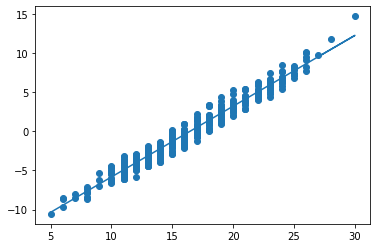

In [118]:
plt.scatter(ww_trues, np.array(ww_trues) - np.array(ww_preds_mean))
plt.plot(ww_trues, lr.coef_*ww_trues + lr.intercept_)


# With base parameters

In [8]:
base_who_mapping = {
    "clusters":
        ("RandomForestRegressor",
         {"random_state": 42}),

    "Words":
        ("AdaBoostRegressor",
         {"random_state": 42}),

    "RuLIWC":
        ("Lasso",
         {"random_state": 42}),

    "AppCats":
        ("Ridge",
         {"random_state": 42}),

    "Behavior":
        ("DecisionTreeRegressor",
         {"random_state": 42})
}


In [9]:
base_diener_mapping = {
    "clusters": 
        ("RandomForestRegressor", 
         {"random_state": 42}),
    
    "Words": 
        ("ElasticNet",
         {"random_state": 42}),
    
    "RuLIWC": 
        ("RandomForestRegressor",
         { "random_state": 42}),
    
    "AppCats": 
        ("Lasso", 
        {"random_state": 42}),
    
    "Behavior": 
        ("DecisionTreeRegressor",
         {"random_state": 42})
}

In [11]:
d_trues, d_preds_mean, d_preds_mean_round, d_preds_vote, d_bestfeats, d_ests = eval_pars_nested_CV(
    X=traindata, 
    y=g['DF_' + "diener" + '_score'], 
    wb=wb, 
    mapping_models=base_diener_mapping,
    mapping_features=prepared_columns_index,
    step=1, 
    bestfs=True
)

Model predicting in CV #0:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation #0


Model predicting in CV #1:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.31126707570648576, r2 0.08578022726142798 mae 0.21581703318240159
MEAN and ROUND
CV: pr 0.30529014729121284, r2 0.08540666790093554 mae 0.21473684210526314
ROUND and VOTE
CV: pr 0.05679719396536658, r2 -0.0060526653089709725 mae 0.2242105263157895
Cross-validation #1


Model predicting in CV #2:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr -0.010214552867152116, r2 -0.06965435581488233 mae 0.23728370005875934
MEAN and ROUND
CV: pr 0.014191377785660236, r2 -0.0592748351898158 mae 0.23578947368421052
ROUND and VOTE
CV: pr 0.20241954152862254, r2 0.03250738804273701 mae 0.22526315789473686
Cross-validation #2


Model predicting in CV #3:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.12446092363283573, r2 -0.0017156874842876313 mae 0.21314156247959798
MEAN and ROUND
CV: pr 0.12727785229823382, r2 -1.7052042834864167e-05 mae 0.212972972972973
ROUND and VOTE
CV: pr -0.16370714515752408, r2 -0.04890116635972985 mae 0.2227027027027027
Cross-validation #3


Model predicting in CV #4:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.1976438830734011, r2 0.0366728279946863 mae 0.22077273059166636
MEAN and ROUND
CV: pr 0.21350797546725964, r2 0.04193744922826981 mae 0.22054054054054054
ROUND and VOTE
CV: pr 0.01032313864504306, r2 -0.049811129163281676 mae 0.22032432432432433
Cross-validation #4


Model predicting in CV #5:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr -0.23663098221146994, r2 -0.17875746128718162 mae 0.2324617674983569
MEAN and ROUND
CV: pr -0.2653291385306525, r2 -0.1989854022155504 mae 0.23351351351351352
ROUND and VOTE
CV: pr -0.09214622679370293, r2 -0.03079545846706022 mae 0.21794594594594593
Cross-validation #5


Model predicting in CV #6:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.21114264991626802, r2 0.04317321054297618 mae 0.22203063849804874
MEAN and ROUND
CV: pr 0.17389928624873002, r2 0.024288688410825765 mae 0.22486486486486487
ROUND and VOTE
CV: pr 0.38194519849767766, r2 0.07441921945738728 mae 0.2118918918918919
Cross-validation #6


Model predicting in CV #7:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.07814084877215752, r2 -0.03889082702564184 mae 0.22946038532501767
MEAN and ROUND
CV: pr 0.11311802559005564, r2 -0.016168592267475246 mae 0.227027027027027
ROUND and VOTE
CV: pr 0.2244450330021737, r2 0.0357742206157623 mae 0.2172972972972973
Cross-validation #7


Model predicting in CV #8:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.07840618344083096, r2 -0.022656782590701807 mae 0.22442118524161575
MEAN and ROUND
CV: pr 0.06746843461682557, r2 -0.028759793617427976 mae 0.22486486486486487
ROUND and VOTE
CV: pr 0.0060052568480748955, r2 -0.016645646219504373 mae 0.21924324324324324
Cross-validation #8


Model predicting in CV #9:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr -0.21731323106044892, r2 -0.1438106826065253 mae 0.22937218714381455
MEAN and ROUND
CV: pr -0.16709088995912816, r2 -0.12656968589973605 mae 0.22594594594594594
ROUND and VOTE
CV: pr -0.16869776872123582, r2 -0.10236080759320298 mae 0.22875675675675677
Cross-validation #9


Model predicting in CV #9: 100%|██████████| 5/5 [01:36<00:00, 19.23s/it]

MEAN
CV: pr -0.09180290183063772, r2 -0.10707974951479127 mae 0.22174791156781923
MEAN and ROUND
CV: pr -0.07087193833792305, r2 -0.10084729255940794 mae 0.2172972972972973
ROUND and VOTE
CV: pr 0.07534425434199649, r2 -0.0017530190884300634 mae 0.22054054054054054
Dev final:  0.2233
Test mean:  [0.2247, 0.0445, -0.0397]
Test mean round:  [0.2238, 0.0511, -0.0379]
Test round vote:  [0.2208, 0.0533, -0.0114]


In [12]:
w_trues, w_preds_mean, w_preds_mean_round, w_preds_vote, w_bestfeats, w_ests = eval_pars_nested_CV(
    X=traindata, 
    y=g['DF_' + "who" + '_score'], 
    wb=wb, 
    mapping_models=base_who_mapping,
    mapping_features=prepared_columns_index,
    step=1, 
    bestfs=True
)

Model predicting in CV #0:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation #0


Model predicting in CV #1:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.18504851311795498, r2 0.026926449404008013 mae 0.16023614254563281
MEAN and ROUND
CV: pr 0.17324085231659903, r2 0.019279919991110006 mae 0.16105263157894736
ROUND and VOTE
CV: pr 0.47176252370627936, r2 0.16665185020557838 mae 0.14757894736842103
Cross-validation #1


Model predicting in CV #2:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.3769564624824946, r2 0.12114825721858968 mae 0.15335991968147658
MEAN and ROUND
CV: pr 0.3774067868897918, r2 0.12188118007206128 mae 0.15473684210526314
ROUND and VOTE
CV: pr 0.22541557597374504, r2 0.04990220247609245 mae 0.156
Cross-validation #2


Model predicting in CV #3:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.46315801423010905, r2 0.15450723940167244 mae 0.1388250517255015
MEAN and ROUND
CV: pr 0.42510790439824, r2 0.12715917201998583 mae 0.14162162162162162
ROUND and VOTE
CV: pr 0.4330148894147102, r2 0.14284653818700943 mae 0.14313513513513515
Cross-validation #3


Model predicting in CV #4:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.49518651075775183, r2 0.18714406395992 mae 0.1295273507215753
MEAN and ROUND
CV: pr 0.49039126460479576, r2 0.1871502590673575 mae 0.12756756756756757
ROUND and VOTE
CV: pr 0.3800806666128967, r2 0.1027979274611398 mae 0.1427027027027027
Cross-validation #4


Model predicting in CV #5:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.22376631532310853, r2 0.045439923931174575 mae 0.15136839730917376
MEAN and ROUND
CV: pr 0.20803832690301122, r2 0.03443093318759405 mae 0.15135135135135136
ROUND and VOTE
CV: pr 0.37066597251382255, r2 0.1340210411258369 mae 0.14097297297297298
Cross-validation #5


Model predicting in CV #6:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.28707808102548027, r2 0.08218135438435037 mae 0.1443603800742471
MEAN and ROUND
CV: pr 0.30226107137128927, r2 0.09018530261396462 mae 0.1427027027027027
ROUND and VOTE
CV: pr 0.1133466624461024, r2 -0.00919044599450447 mae 0.15178378378378377
Cross-validation #6


Model predicting in CV #7:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.4390216042974976, r2 0.17322173290093112 mae 0.13726770547557046
MEAN and ROUND
CV: pr 0.4158493791335004, r2 0.15896954827536447 mae 0.13837837837837838
ROUND and VOTE
CV: pr 0.4869246834398126, r2 0.1940525328330207 mae 0.13643243243243242
Cross-validation #7


Model predicting in CV #8:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.1415043166597456, r2 0.003163594081988075 mae 0.1414295467566591
MEAN and ROUND
CV: pr 0.14969435473814188, r2 0.0012335824686162677 mae 0.13837837837837838
ROUND and VOTE
CV: pr 0.04061262061684828, r2 -0.05053044046150479 mae 0.1561081081081081
Cross-validation #8


Model predicting in CV #9:   0%|          | 0/5 [00:00<?, ?it/s]

MEAN
CV: pr 0.43424670148911926, r2 0.16840950032422952 mae 0.1337293219387105
MEAN and ROUND
CV: pr 0.4040744276184022, r2 0.15290377884134565 mae 0.13513513513513514
ROUND and VOTE
CV: pr 0.4920484322388741, r2 0.22653903850275015 mae 0.12843243243243246
Cross-validation #9


Model predicting in CV #9: 100%|██████████| 5/5 [03:38<00:00, 43.78s/it] 

MEAN
CV: pr 0.22964041308604247, r2 0.04709866672777485 mae 0.15048954560543318
MEAN and ROUND
CV: pr 0.19145111878222554, r2 0.031235065201065115 mae 0.15027027027027026
ROUND and VOTE
CV: pr 0.1277401629299523, r2 -0.010850003413668263 mae 0.1543783783783784
Dev final:  0.1494
Test mean:  [0.1441, 0.3276, 0.1009]
Test mean round:  [0.1441, 0.3138, 0.0924]
Test round vote:  [0.1458, 0.3142, 0.0946]
